In [1]:
import numpy as np
import pandas as pd
from osgeo import gdal
from gdalconst import * 

import sys, os, time

from matplotlib import pyplot as plt
%matplotlib inline

from PIL import Image

from IPython.display import clear_output

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Load data in GeoTiff format

Let's look at the VIIRS data of night lights. This data is acquired monthly and is available since 2012. The spatial resolution is $0.5 \ km^2/px$.
The data is provided as a set of 6 tiles that span most of the globe (two files per tile).

In [2]:
# list of files 

# files = """http://mapserver.ngdc.noaa.gov/viirs_data/viirs_composite/v10//201609/vcmcfg/SVDNB_npp_20160901-20160930_75N180W_vcmcfg_v10_c201610280941.tgz
# http://mapserver.ngdc.noaa.gov/viirs_data/viirs_composite/v10//201609/vcmcfg/SVDNB_npp_20160901-20160930_75N060W_vcmcfg_v10_c201610280941.tgz
# http://mapserver.ngdc.noaa.gov/viirs_data/viirs_composite/v10//201609/vcmcfg/SVDNB_npp_20160901-20160930_75N060E_vcmcfg_v10_c201610280941.tgz
# http://mapserver.ngdc.noaa.gov/viirs_data/viirs_composite/v10//201609/vcmcfg/SVDNB_npp_20160901-20160930_00N180W_vcmcfg_v10_c201610280941.tgz
# http://mapserver.ngdc.noaa.gov/viirs_data/viirs_composite/v10//201609/vcmcfg/SVDNB_npp_20160901-20160930_00N060W_vcmcfg_v10_c201610280941.tgz
# http://mapserver.ngdc.noaa.gov/viirs_data/viirs_composite/v10//201609/vcmcfg/SVDNB_npp_20160901-20160930_00N060E_vcmcfg_v10_c201610280941.tgz""".split("\n")

In [3]:
rast_file = "/home/ubuntu/data/VIIRS/2016-09/SVDNB_npp_20160901-20160930_75N180W_vcmcfg_v10_c201610280941.avg_rade9.tif"

### Using plain GDAL

In [4]:
rast = gdal.Open(rast_file, GA_ReadOnly)
rast

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f4a0f0ecf00> >

In [5]:
cols = rast.RasterXSize
rows = rast.RasterYSize
bands = rast.RasterCount
driver = rast.GetDriver().LongName
print "Data size: %d x %d x %d (cols x rows x bands)"%(cols, rows, bands)
print driver

Data size: 28800 x 18000 x 1 (cols x rows x bands)
GeoTIFF


In [6]:
geotransform = rast.GetGeoTransform()
originX = geotransform[0]
originY = geotransform[3]
pixelWidth = geotransform[1]
pixelHeight = geotransform[5]

In [7]:
print originX, originY, pixelWidth, pixelHeight

-180.002083333 75.0020833334 0.0041666667 -0.0041666667


In [8]:
band = rast.GetRasterBand(1)
bandtype = gdal.GetDataTypeName(band.DataType)
print bandtype

Float32


In [9]:
band.XSize, band.YSize

(28800, 18000)

In [10]:
data = band.ReadAsArray(0, 0, cols, rows)
value = data[3500,4000]
print value

data = band.ReadAsArray(0, 0, rast.RasterXSize, rast.RasterYSize).astype(np.float)
value = data[3500,4000]
print value


0.0
0.0


### Using rasterio

In [11]:
import rasterio
rast2 = rasterio.open(rast_file)

In [12]:
rast2.name, rast2.mode

('/home/ubuntu/data/VIIRS/2016-09/SVDNB_npp_20160901-20160930_75N180W_vcmcfg_v10_c201610280941.avg_rade9.tif',
 'r')

In [13]:
arr = rast2.read(1)

In [14]:
arr.shape

(18000, 28800)

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1298: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=400:stretch=normal:size=medium. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


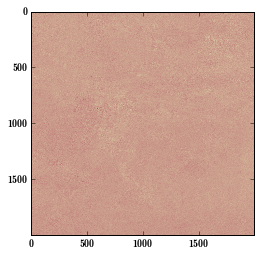

In [15]:
plt.imshow(arr[6000:8000,6000:8000], cmap='pink')
plt.show()  

# Extract regions of interest

### Utilities in satimg

In [16]:
import sys
sys.path.append("../satimage-processing/")
import satimg 

In [17]:
bounds = satimg.get_geotiff_bounds(rast)
bounds 

(0.002082733349993761,
 -180.00208333335016,
 75.00208333335007,
 -60.002082373350035)

In [18]:
loc = (37.7749, -122.4194) # San Francisco lat/lon

In [19]:
bbox = satimg.bounding_box_at_location(loc, (100,100))
print bbox

(37.32517953888292, -122.98836144499806, 38.224620461117084, -121.85043855500192)


In [20]:
geoSize = satimg.km_to_deg_at_location(loc, (100,100))
print geoSize

(0.899440922234163, 1.1379228899961475)


### Using SatSense class

In [57]:
simg = satimg.SatImage(rast_file)

In [58]:
img = simg.get_image_at_location(loc)
img

74.845596313476562

In [38]:
img.shape, np.squeeze(img).shape

((1, 27, 22), (27, 22))

In [30]:
img = simg.get_image_at_location(loc, w=10)
img.shape

(1, 27, 22)

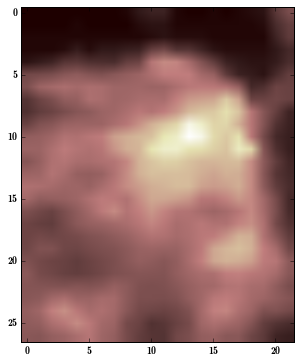

In [31]:
plt.figure(figsize=(8,6))
plt.imshow(img[0], cmap='pink')

In [ ]:
import geocoder
locs = ["San Francisco, CA", "Cambridge, MA", "Toronto, Canada"]
locs = [tuple(geocoder.google(l).latlng) for l in locs]

In [ ]:
locs

In [ ]:
images = simg.get_image_at_locations(locs, w=100)

In [ ]:
for i in images.values():
    plt.figure(figsize=(8,4))
    plt.imshow(i[0], cmap='pink')

In [ ]:
satimg.generate_locations_within_bounding_box(bbox, 10)

In [ ]:
bbox

In [ ]:
from shapely.geometry import Polygon, Point
p = Polygon([(bbox[1], bbox[0]), ([bbox[1], bbox[2]]), (([bbox[3], bbox[2]])), ([bbox[3], bbox[0]])])

In [ ]:
satimg.generate_locations_within_polygon(p, 10)

In [ ]:
sampleImages = simg.sample_images_around_location(loc, w=5, W=100, nSamples=10)

In [ ]:
len(sampleImages)

In [ ]:
for l,i in sampleImages.iteritems():
    plt.imshow(i[0])
    plt.show()

### Open raster data with rasterio

In [ ]:
import rasterio
from rasterio.tools.mask import mask

# the polygon GeoJSON geometry
geoms = [{'type': 'Polygon', 
          'coordinates': [[(bbox[1], bbox[0]), ([bbox[1], bbox[2]]), (([bbox[3], bbox[2]])), ([bbox[3], bbox[0]])]]}]

# load the raster, mask it by the polygon and crop it
src = rasterio.open(rast_file)
out_image, out_transform = mask(src, geoms, crop=True)
out_meta = src.meta.copy()

print out_image.data.sum()

# # save the resulting raster  
# out_meta.update({"driver": "GTiff",
#     "height": out_image.shape[1],
#     "width": out_image.shape[2],
# "transform": out_transform})

# with rasterio.open("masked.tif", "w", **out_meta) as dest:
#     dest.write(out_image)

In [ ]:
plt.imshow(out_image.data[0,:,:])

# Display map using ipyleaflet

In [59]:
# json
import json

# widgets
import ipyleaflet as ll

In [62]:
m = ll.Map(center=loc, zoom=10)

In [63]:
m

In [ ]:
with open('./europe_110.geo.json') as f:
    data = json.load(f)

for feature in data['features']:
    feature['properties']['style'] = {
        'color': 'grey',
        'weight': 1,
        'fillColor': 'grey',
        'fillOpacity': 0.5
    }

layer = ll.GeoJSON(data=data, hover_style={'fillColor': 'red'})

def hover_handler(event=None, id=None, properties=None):
    sys.stdout.write("\r" + properties['geounit'])
    sys.stdout.flush()
    
layer.on_hover(hover_handler)
    
map.add_layer(layer)

map